In [1]:
from matplotlib import pyplot as plt

from pyloki.config import ParamLimits, PulsarSearchConfig
from pyloki.search import ffa_search
from pyloki.simulation.pulse import PulseSignalConfig

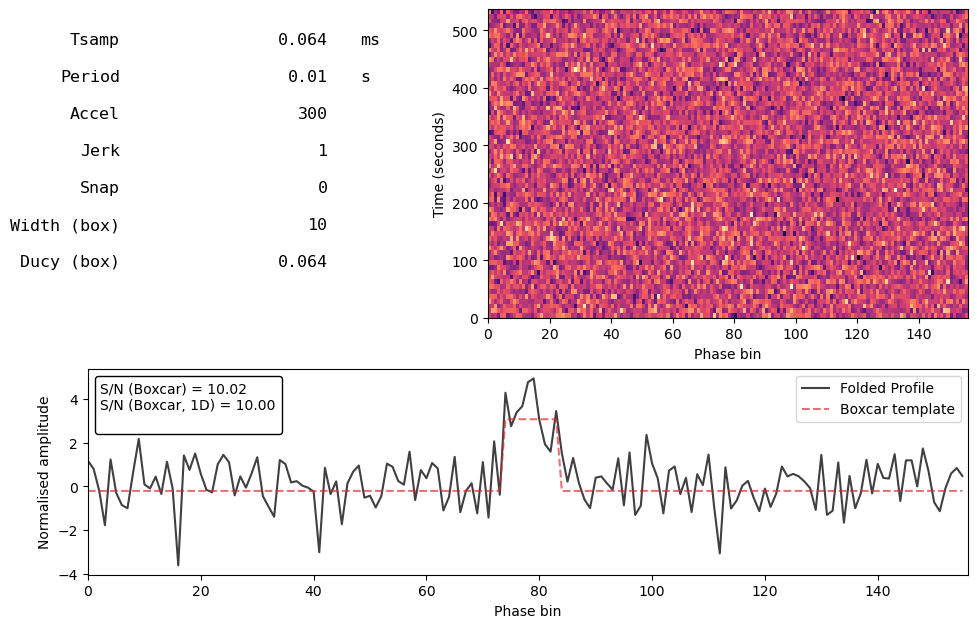

In [2]:
pulsar_period = 0.010
dt = 64e-6
accel = 300
jerk = 1
nsamps = 2**23
mod_kwargs = {"acc": accel, "jerk": jerk}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=10, ducy=0.1,
                        mod_kwargs=mod_kwargs)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 2 #cfg.tol_bins
fold_bins = 64# cfg.fold_bins
p = ParamLimits.from_upper([jerk, accel, cfg.freq], (-2.5, 2.5), cfg.tobs)
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, ducy_max=0.2, wtsp=1.5, use_fft_shifts=False)
dyp, pgram = ffa_search(tim_data, search_cfg, quiet=True, show_progress=True)

Output()

Param limits: [(np.float64(-2.5), np.float64(2.5)), (np.float64(-371.08863999999994), np.float64(971.0886399999999)), (np.float64(99.9430930883033), np.float64(100.05690691169669))]


In [4]:
print(pgram.get_indices_summary(true_values={"jerk": cfg.mod_kwargs["jerk"], "accel": cfg.mod_kwargs["acc"], "freq": cfg.freq},))
print(pgram.get_summary())

True param indices: (30, 128, 488)
Best param indices: (np.int64(30), np.int64(128), np.int64(488), np.int64(4))
Best S/N: 8.37
Best Period: 0.01
Best jerk: 1.0227272727272727
Best accel: 297.4089241698842
Best freq: 100.0
Best width: 6


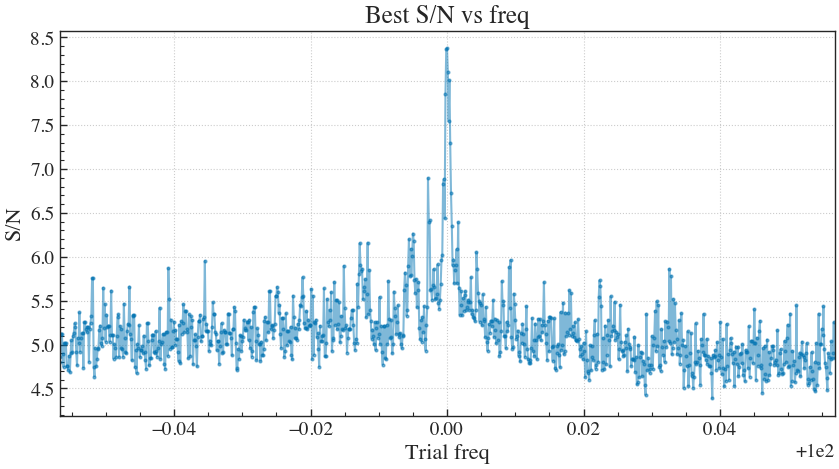

In [5]:
fig = pgram.plot_1d("freq", figsize=(10, 5))
plt.show()

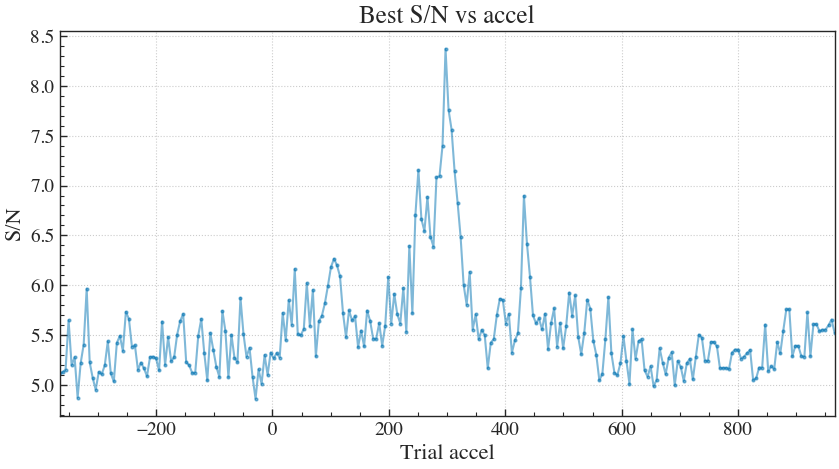

In [6]:
fig = pgram.plot_1d("accel", figsize=(10, 5))
plt.show()

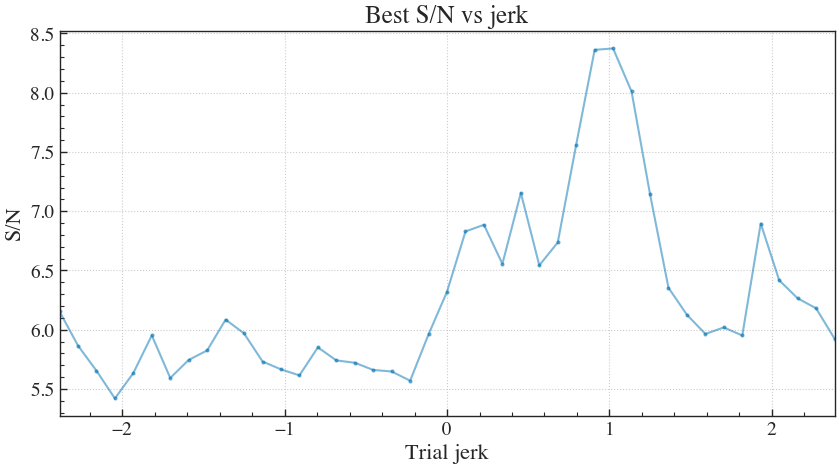

In [7]:
fig = pgram.plot_1d("jerk", figsize=(10, 5))
plt.show()

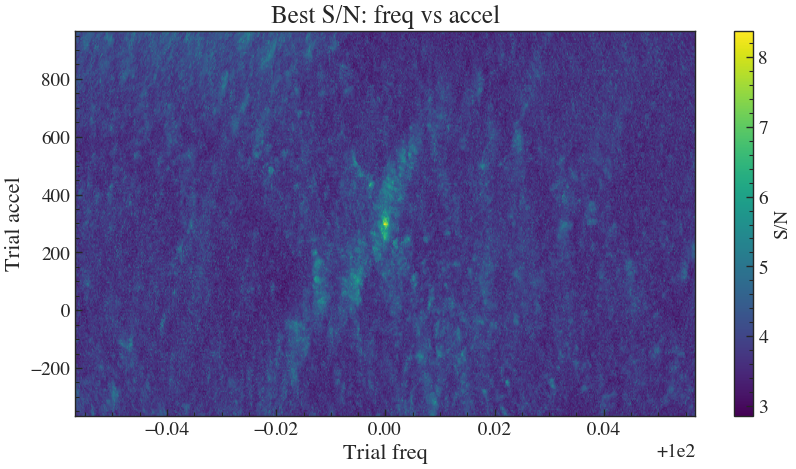

In [8]:
fig = pgram.plot_2d("freq", "accel", figsize=(10, 5))
plt.show()

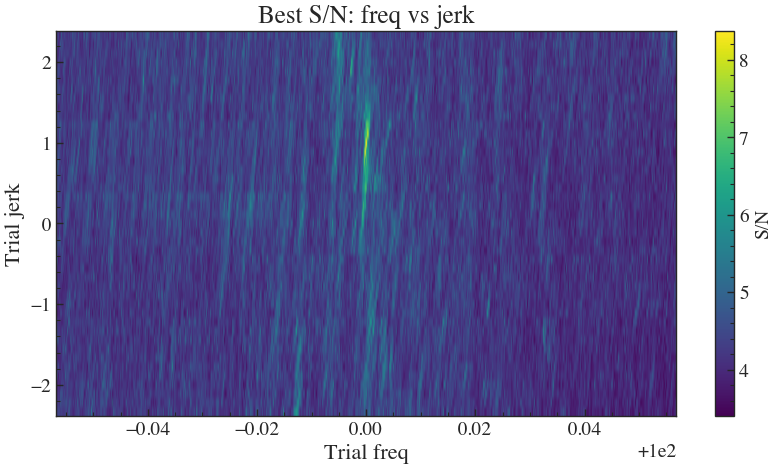

In [9]:
fig = pgram.plot_2d("freq", "jerk", figsize=(10, 5))
plt.show()

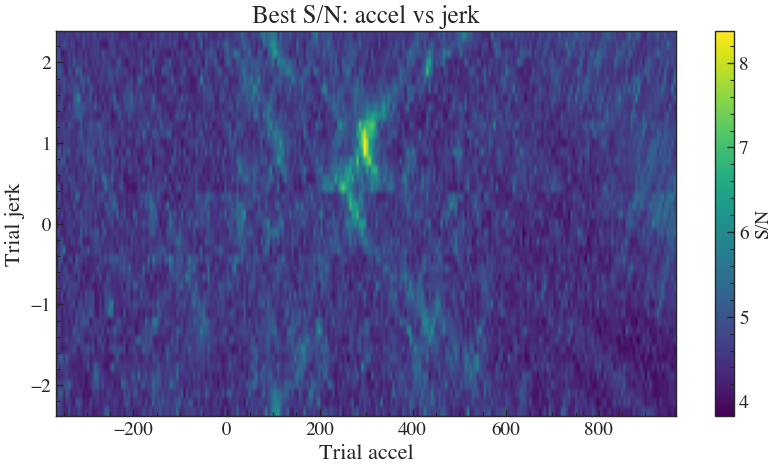

In [10]:
fig = pgram.plot_2d("accel", "jerk", figsize=(10, 5))
plt.show()

### FFT-SHIFT search

In [11]:
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, ducy_max=0.2, wtsp=1.5, use_fft_shifts=True)
dyp, pgram = ffa_search(tim_data, search_cfg, quiet=True, show_progress=True)

Output()

In [12]:
print(pgram.get_indices_summary(true_values={"jerk": cfg.mod_kwargs["jerk"], "accel": cfg.mod_kwargs["acc"], "freq": cfg.freq},))
print(pgram.get_summary())

True param indices: (30, 128, 488)
Best param indices: (np.int64(30), np.int64(128), np.int64(488), np.int64(4))
Best S/N: 9.03
Best Period: 0.01
Best jerk: 1.0227272727272727
Best accel: 297.4089241698842
Best freq: 100.0
Best width: 6


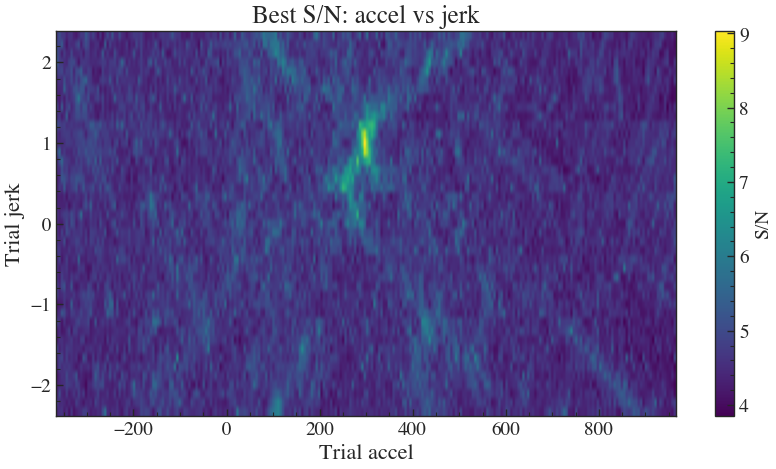

In [13]:
fig = pgram.plot_2d("accel", "jerk", figsize=(10, 5))
plt.show()